In [ ]:
#correlation and cross-correlation between spikes and lfp
#majority of the results

In [ ]:
import warnings
import scipy.signal
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as mpl
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec

# local imports
from database.db_setup import *
from visualization.scr_utils import *
import analysis.stats_code.compute_pvalues as cp

warnings.filterwarnings("ignore")

import utils.helper_func as hf

import random
import scipy.stats


In [2]:
filtering_types = ['theta', 'slow_gamma', 'fast_gamma']
interesting_units_53 = [4, 6, 24, 31]
interesting_units_46 = [1, 7, 8, 16, 18, 26, 29, 31, 33, 37, 42, 45, 46, 59, 67, 68, 69, 88]
interesting_units = [interesting_units_46, interesting_units_53]
interesting_units_46_dict = {1:2, 7:8, 8:8, 16:12, 18:12, 26:26, 29:26, 31:28, 33:29, 37:29, 42:41, 45:42, 46:42, 59:47, 67:52, 68:52, 69:52, 88:67}
interesting_units_53_dict = {4:5, 6:11, 24:45, 31:54}
interesting_units_dict = [interesting_units_46_dict, interesting_units_53_dict]
units_stim_dict_46 = {1:['Paul'], 7:['Alison', 'Paul', 'A Woman'], 8:['Jaws'], 16:['Rachel', 'Paul'], 18:['Black Swan'], 26:['Summer', 'Vance'], 29:['The graduate'], 31:['Tom', 'Summer'], 
                      33:['Alison'], 37:['Rachel', 'A Man'], 42:['Alison', 'Rachel', 'Vance', 'Summer', 'Tom', 'Paul'], 45:['Tom', 'Rachel', 'Summer', 'Tom'],
                      46:['Summer'], 59:['Vance'], 67: ['Titanic'], 68:['Tom'], 69:['Summer'], 88:['Tom', 'Vance']}
units_stim_dict_53 = {4:['Rachel', 'Paul'], 6:['McKenzie'], 24:['Summer'], 31:['Tom']}
units_stim_dict = [units_stim_dict_46, units_stim_dict_53]

sig_units_46 = [16, 31, 33, 42, 45, 46, 67, 68, 69, 88]
sig_units_53 = [24]
sig_units = [sig_units_46, sig_units_53]
sig_units_stim_dict_46 = {16:['Rachel'], 31:['Summer'], 33:['Alison'], 42:['Summer', 'Tom', 'Paul', 'Rachel'], 45:['Summer', 'Tom', 'Rachel'], 46:['Summer'], 67:['Titanic'], 68:['Tom'], 69:['Summer'], 88:['Tom']}
sig_units_stim_dict_53 = {24:['Summer']}
sig_units_stim_dict = [sig_units_stim_dict_46, sig_units_stim_dict_53]

top_dir = '/home/anastasia/epiphyte/anastasia/output'
patients = [46, 53]

fs = 32768
#The resulting sample rate is up / down times the original sample rate.
up = 1
down=32
fs_downs = (up/down)*fs
dt = 1/fs_downs      # sampling period/time/interval or time resolution, often denoted as T

signal_len = np.int(fs_downs*1.4)+1
times = np.linspace(-0.4, 1, signal_len)
times = times*1000

In [11]:
"""
Functions for plotting the screening results. 
Adapted from Johannes Niediek's original standalone code to interface withe database 
"""

import warnings
import scipy.signal
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as mpl
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec

# local imports
from database.db_setup import *

from visualization.scr_utils import *
import analysis.stats_code.compute_pvalues as cp

warnings.filterwarnings("ignore")

import utils.helper_func as hf

# constants 

EMPTY = np.array([])
OUTFOLDER = 'pvalues'

PVAL_CUTOFF = .1
MIN_ACTIVE_TRIALS = 3

FIGSIZE = (12, 12)
T_PRE = 1000
T_POST = 2000
HIST_BIN_WIDTH = 10
HIST_BINS = np.arange(-T_PRE, T_POST + 1, HIST_BIN_WIDTH)

POSITIONS = ('pre', 'post')
COLORS = ('blue', 'green')

DPI = 200

fs = 32768
up = 1
down=32
fs_downs = (up/down)*fs
signal_len = np.int(fs_downs*1.5)+1
times = np.linspace(-0.5, 1, signal_len)
times = times*1000
t400 = -400
t1 = 0
t2 = 1000
idx400 = np.where(times == hf.find_nearest(times, t400))[0][0]
idx1 = np.where(times == hf.find_nearest(times, t1))[0][0]
idx2 = np.where(times == hf.find_nearest(times, t2))[0][0]

def make_one_lfp_spike_correlation(sp_times, event_data, pvalues, amplitude_envelope_pre, amplitude_envelope_post, std_pre, std_post):
    
    sep = .2
    hist_max = 0
    time_data = []
    color_data = []
    hist_data = []
    
    events = event_data.loc[event_data.position == 'post', 'time'].values
    for event in events:
        idx_sp = (sp_times >= event - T_PRE) & (sp_times <= event + T_POST)
        if idx_sp.any():
            temp = sp_times[idx_sp] - event
            time_data.append(temp)
            t_hist, _ = np.histogram(temp, HIST_BINS)   
            hist_data.append(t_hist * 1000 / HIST_BIN_WIDTH)
        else:
            time_data.append([-2*T_PRE])   # hack of eventplot
            
    if len(hist_data):
        hist = np.vstack(hist_data).mean(0)
        hist_data = np.array(hist_data)
        hist = (hist - np.mean(hist_data[:,50:100])) / np.std(hist_data[:,50:100])
        #hist = (hist - np.mean(hist[50:100])) / np.std(hist[50:100])
        aa = hist[100:200]
        if not np.isnan(aa).any():
            gauss_window = scipy.signal.windows.gaussian(5, std=2)
            aa = np.convolve(aa, gauss_window, mode='same')
            part_spikes = np.nanmean(aa[20:60])
            part_power = np.mean(amplitude_envelope_post[20:60])
            rval, pval = scipy.stats.pearsonr(amplitude_envelope_post, aa) 
            crosscorr_val = np.correlate(amplitude_envelope_post, aa, 'same')
            
        else:
            rval = float('nan')
            pval = float('nan')
            part_power = float('nan')
            part_spikes = float('nan')
            crosscorr_val = float('nan')
    else: 
        rval = float('nan')
        pval = float('nan')
        part_power = float('nan')
        part_spikes = float('nan')
        crosscorr_val = float('nan')
              
    return rval, pval, part_spikes, part_power, crosscorr_val, hist_data, aa

            
def run_session_corr(df_patient_info, interesting_units, interesting_units_dict, units_stim_dict, units, stims, spiking_resp, pat_ids, patient_id, filtering_type):
    """
    load stimulus frame and channel list for one session
    """  
    folder=f'05-Hilbert_transform_{patient_id}'
    spgram_data = f'04-spectrogram_wavelet_{patient_id}'
    norm_type = 'zscore'
    session_nr = get_session_info(patient_id)
    
    assert isinstance(session_nr, int), "More than one session for patient {}. Code currently not set up for automatically running multiple sessions from a single patient.".format(patient_id)
    
    position, stim_id, filename, stim_name, is_500_days, paradigm, time = get_screening_data(patient_id, session_nr)
    frame = cp.make_dataframe(position, stim_id, filename, stim_name, is_500_days, paradigm, time)
    
    stim_data = {}
    stim_nums = frame.stim_num.unique()

    for stim_num in stim_nums:
        meta = frame.loc[frame.stim_num == stim_num, :].iloc[0]
        stim_fname = meta["filename"]
        stim_data[stim_fname] = (stim_num,
                                meta["stim_name"],
                                meta["paradigm"],
                                mpl.imread(os.path.join(PATH_TO_IMAGES, stim_fname))) ## read image file into an array

    all_channels = get_cscs_for_patient(patient_id, session_nr)
    
    df_corr_all = pd.DataFrame()
    units_spikes = []
    units_power = []
    positions = []
    ampl_pre = []
    ampl_post = []
    all_hists = []
    stim_numbers = []
    image_names = []
    rvals = []
    pvals = []
    parts_spikes = []
    parts_power = []
    spgrams_pre = []
    spgrams_post = []
    crosscorr_vals = []
    hists = []
    all_spikes = []
    for unit in interesting_units:
        #print("Running unit {}...".format(unit))
        ch = interesting_units_dict[unit]
        ch_site = df_patient_info.loc[ch-1,'recording_site']
        df_corr = pd.DataFrame()

        spikes = get_spiking_activity(patient_id, session_nr, unit)

        stim_index, eventtimes = get_scr_eventtimes(patient_id, session_nr)

        region = get_brain_region(patient_id, unit)
        unit_type = get_unit_type(patient_id, session_nr, unit)

        unit_pvals = get_scr_stats_as_df(patient_id, session_nr, unit)

        times = spikes
        save_unit = False
        num_stimuli = len(np.unique(frame["filename"]))

        if num_stimuli == 42:
            img_order = IMAGE_ORDER_ALL
        elif num_stimuli == 35:
            img_order = IMAGE_ORDER_NO_TEXT
        else: 
            raise Exception("Irregular number of stimuli for patient.")

        for i_row, row in enumerate(img_order):
            for i_col, img_fname in enumerate(row):
                stim_num, stim_name, paradigm, image = stim_data[img_fname]
                stim_numbers.append(stim_num)
                image_names.append(stim_name)

                if stim_name == '???':
                    ampl_envelope_pre = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_unknown_amplitude_envelope_{norm_type}_pre.npy')
                    ampl_envelope_post = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_unknown_amplitude_envelope_{norm_type}_post.npy')
                #    spgram_pre = np.load(f'{top_dir}/{spgram_data}/spectrograms/normalized/{norm_type}/CSC{ch}_{ch_site}_{stim_num}_unknown_pre_{norm_type}.npy')
                #    spgram_post = np.load(f'{top_dir}/{spgram_data}/spectrograms/normalized/{norm_type}/CSC{ch}_{ch_site}_{stim_num}_unknown_post_{norm_type}.npy')
                else:
                    ampl_envelope_pre = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_{stim_name}_amplitude_envelope_{norm_type}_pre.npy')
                    ampl_envelope_post = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_{stim_name}_amplitude_envelope_{norm_type}_post.npy')
                #    spgram_pre = np.load(f'{top_dir}/{spgram_data}/spectrograms/normalized/{norm_type}/CSC{ch}_{ch_site}_{stim_num}_{stim_name}_pre_{norm_type}.npy')
                #    spgram_post = np.load(f'{top_dir}/{spgram_data}/spectrograms/normalized/{norm_type}/CSC{ch}_{ch_site}_{stim_num}_{stim_name}_post_{norm_type}.npy')
                    
                std_pre = np.std(ampl_envelope_pre)
                std_post = np.std(ampl_envelope_post)            
                
                if stim_name in units_stim_dict[unit]:
                    stims.append(stim_name)
                    units.append(unit)
                    pat_ids.append(patient_id)
                    amplitude_envelope_pre = np.mean(ampl_envelope_pre, axis=0)
                    amplitude_envelope_post = np.mean(ampl_envelope_post, axis=0)
                    ampl_pre.append(amplitude_envelope_pre[idx400:idx2])
                    ampl_post.append(amplitude_envelope_post[idx400:idx2])
                    position = np.argmax(np.abs(amplitude_envelope_post) > 1)
                    amplitude_envelope_pre = amplitude_envelope_pre[idx1:idx2]
                    amplitude_envelope_post = amplitude_envelope_post[idx1:idx2]
                    #position = np.abs(amplitude_envelope_post - np.mean(amplitude_envelope_post)) > 2 #bc zscore is already on the scale of std
                    positions.append(position)
                    #spgrams_pre.append(spgram_pre)
                    #spgrams_post.append(spgram_post)

                    #DOWNSAMPLE
                    amplitude_envelope_pre = scipy.signal.resample(amplitude_envelope_pre, 100)
                    amplitude_envelope_post = scipy.signal.resample(amplitude_envelope_post, 100)
                
                    rval, pval, part_spikes, part_power, crosscorr_val, hist, aa = make_one_lfp_spike_correlation(times, frame.loc[frame.stim_num == stim_num, ['position', 'time']],
                        unit_pvals.loc[unit_pvals.stim_num == stim_num, :], amplitude_envelope_pre, amplitude_envelope_post, std_pre, std_post)
                    spiking_resp.append(part_spikes)
                    all_spikes.append(aa)
                    
                else:
                    rval, pval, part_spikes, part_power, crosscorr_val, hist = float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan')
                rvals.append(rval)
                pvals.append(pval)
                parts_spikes.append(part_spikes)
                parts_power.append(part_power)
                crosscorr_vals.append(crosscorr_val)
                hists.append(hist)
        
        df_corr[f'rvals_{unit}'] = rvals
        df_corr[f'pvals_{unit}'] = pvals
        
        df_corr = df_corr.add_suffix(f'_unit-{unit}')
        df_corr_all = pd.concat([df_corr_all, df_corr], axis=1)
        units_spikes.append(parts_spikes)
        units_power.append(parts_power)
        
    df_corr_all.insert(loc=0, column='stim_numbers', value=stim_numbers)
    df_corr_all.insert(loc=0, column='image_names', value=image_names)
    
    #spgrams_pre, spgrams_post,
    return df_corr_all, units_spikes, units_power, positions, ampl_pre, ampl_post, units, stims, spiking_resp, pat_ids, crosscorr_vals, hists, all_spikes


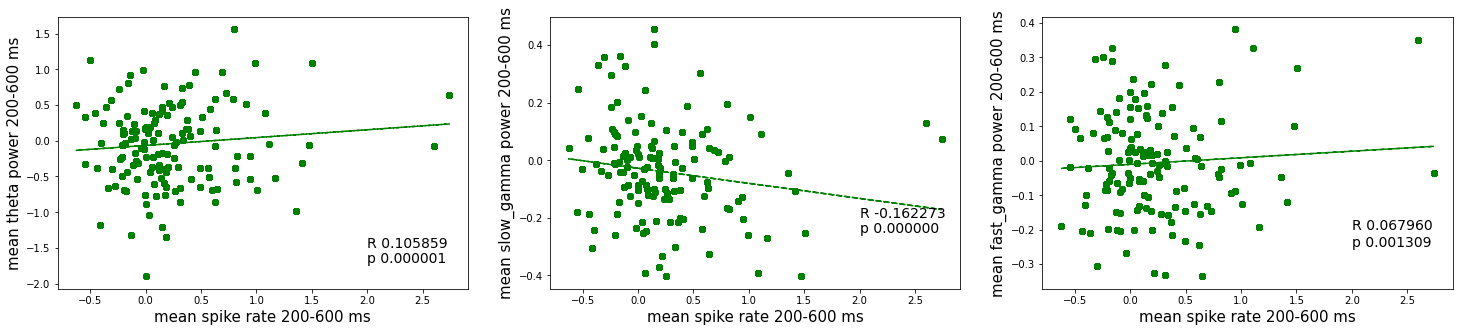

In [13]:
fig, axs = mpl.subplots(1,3, figsize=(25,5))
patients = [46, 53]
x_positions = [2]
y_positions = [-1.5, -0.2, -0.2]
y_difference = [-0.2, -0.05, -0.05]

for i in range(len(filtering_types)):
    filtering_type = filtering_types[i]
    units_spikes = []
    units_power = []
    positions = []
    spgrams_pre = []
    spgrams_post = []
    ampls_pre = []
    ampls_post = []
    units = []
    stims = []
    spiking_resp = []
    pat_ids = []
    sig_units_spikes = []
    sig_units_power = []
    hists = []
    
    for j in range(len(patients)):
        patient_id = patients[j]
        df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')
        
        #spgrams_pre_one, spgrams_post_one,
        df_corr_one, units_spikes_one, units_power_one, positions_one, ampl_pre, ampl_post, units, stims, spiking_resp, pat_ids, crosscorr_val, hist, aa = run_session_corr(df_patient_info, interesting_units[j], interesting_units_dict[j], units_stim_dict[j], units, stims, spiking_resp, pat_ids, patient_id=patient_id, filtering_type=filtering_type)
        df_corr_one = df_corr_one.round(6)
        #df_corr.to_csv(f'{top_dir}/09-corr_lfp_spikes_{patient_id}/df_corr_{filtering_type}.csv')
        units_spikes.append(units_spikes_one)
        units_power.append(units_power_one)
        positions.append(positions_one)
        #spgrams_pre.append(spgrams_pre_one)
        #spgrams_post.append(spgrams_post_one)
        ampls_pre.append(ampl_pre)
        ampls_post.append(ampl_post)
        hists.append(hist)
        
        #select here more responsive
        #df_corr_one, units_spikes_one, units_power_one, positions_one, spgrams_pre_one, spgrams_post_one, ampl_pre, ampl_post, units, stims, spiking_resp, pat_ids, crosscorr_val, hist = run_session_corr(df_patient_info, sig_units[j], interesting_units_dict[j], sig_units_stim_dict[j], units, stims, spiking_resp, pat_ids, patient_id=patient_id, filtering_type=filtering_type)
        #sig_units_spikes.append(units_spikes_one)
        #sig_units_power.append(units_power_one)
     
    units_spikes = [*units_spikes[0], *units_spikes[1]]
    units_power = [*units_power[0], *units_power[1]]
    units_spikes = [item for sublist in units_spikes for item in sublist]
    units_power = [item for sublist in units_power for item in sublist]
    
    idx = np.isfinite(units_spikes) & np.isfinite(units_power)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.array(units_spikes)[idx], np.array(units_power)[idx])
    r_val, p_val = scipy.stats.pearsonr(np.array(units_spikes)[idx], np.array(units_power)[idx]) 
    axs[i].scatter(units_spikes, units_power, color='green')
    axs[i].set_xlabel('mean spike rate 200-600 ms', fontsize=15)
    axs[i].set_ylabel(f'mean {filtering_type} power 200-600 ms', fontsize=15)
    axs[i].plot(np.array(units_spikes)[idx], slope*np.array(units_spikes)[idx] + intercept, linestyle='dashed', color='green')
    axs[i].text(2, y_positions[i], f'R {format(r_val,".6f")}', fontsize=14)
    axs[i].text(2, y_positions[i]+y_difference[i], f'p {format(p_val,".6f")}', fontsize=14)
    
    #sig_units_spikes = [item for sublist in sig_units_spikes for item in sublist]
    #sig_units_power = [item for sublist in sig_units_power for item in sublist]    
    #idx_sig = np.isfinite(sig_units_spikes) & np.isfinite(sig_units_power)
    #m, b = np.polyfit(np.array(sig_units_spikes)[idx_sig], np.array(sig_units_power)[idx_sig], 1)
    #axs[i].scatter(sig_units_spikes, sig_units_power, color='green')
    #mpl.xlabel('mean spike rate 200-700 ms')
    #mpl.ylabel(f'mean {filtering_type} power 200-700 ms')
    #axs[i].plot(np.array(sig_units_spikes)[idx_sig], m*np.array(sig_units_spikes)[idx_sig] + b, linestyle='dashed', color='green')
mpl.show()

r-values
RanksumsResult(statistic=0.2661945408430259, pvalue=0.7900893871761511)
bins
RanksumsResult(statistic=-5.808043245072618, pvalue=6.320719276748362e-09)
r-values
RanksumsResult(statistic=0.60120274337886, pvalue=0.5477049574780907)
bins
RanksumsResult(statistic=-6.083796040090902, pvalue=1.1736989600053166e-09)
r-values
RanksumsResult(statistic=0.9491539543835608, pvalue=0.3425423164750807)
bins
RanksumsResult(statistic=-5.990729471772231, pvalue=2.089018868228532e-09)


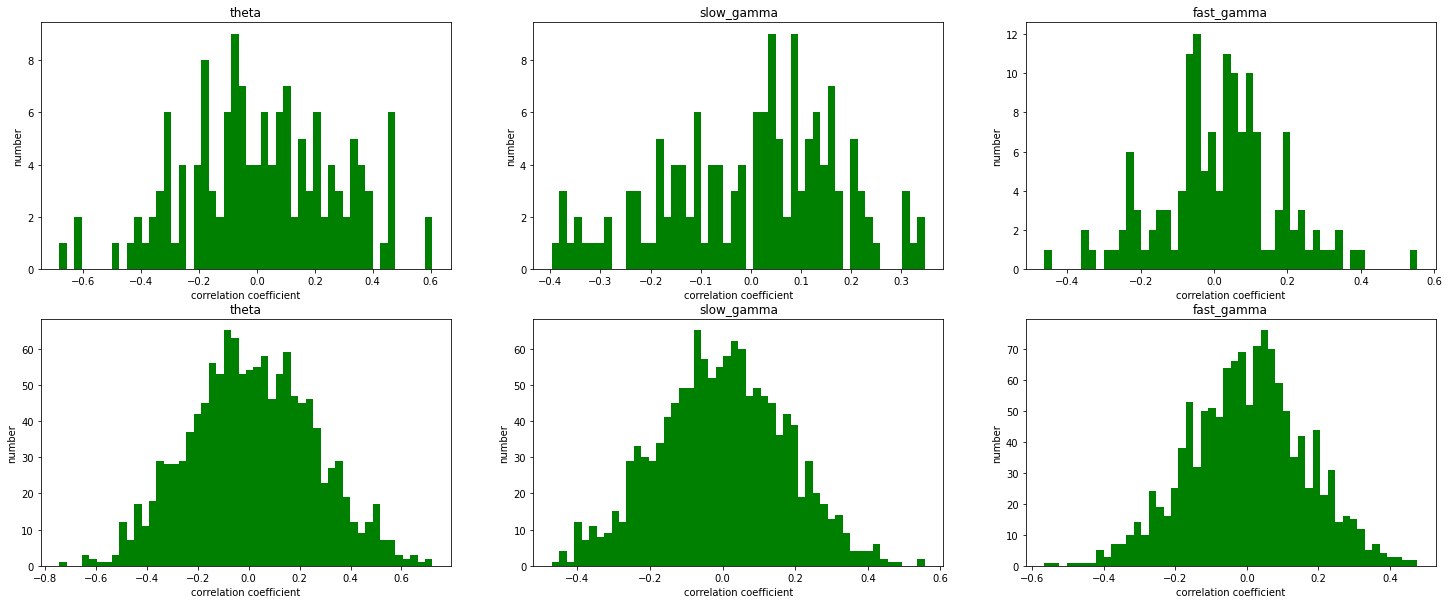

In [59]:
fig, axs = mpl.subplots(2,3, figsize=(25,10))
patients = [46, 53]
for i in range(len(filtering_types)):
    filtering_type = filtering_types[i]
    units_spikes = []
    units_power = []
    positions = []
    spgrams_pre = []
    spgrams_post = []
    ampls_pre = []
    ampls_post = []
    units = []
    stims = []
    spiking_resp = []
    pat_ids = []
    sig_units_spikes = []
    sig_units_power = []
    hists = []
    all_spikes = []
    
    for j in range(len(patients)):
        patient_id = patients[j]
        df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')

        df_corr_one, units_spikes_one, units_power_one, positions_one, spgrams_pre_one, spgrams_post_one, ampl_pre, ampl_post, units, stims, spiking_resp, pat_ids, crosscorr_val, hist, aa = run_session_corr(df_patient_info, interesting_units[j], interesting_units_dict[j], units_stim_dict[j], units, stims, spiking_resp, pat_ids, patient_id=patient_id, filtering_type=filtering_type)
        df_corr_one = df_corr_one.round(6)
        units_spikes.append(units_spikes_one)
        units_power.append(units_power_one)
        positions.append(positions_one)
        spgrams_pre.append(spgrams_pre_one)
        spgrams_post.append(spgrams_post_one)
        ampls_pre.append(ampl_pre)
        ampls_post.append(ampl_post)
        hists.append(hist)
        all_spikes.append(aa)
     
    all_spikes = [*all_spikes[0], *all_spikes[1]]
    ampls_post = [*ampls_post[0], *ampls_post[1]]
    
    rvals = []
    pvals = []
    for k in range(len(all_spikes)):
        if not np.isnan(all_spikes[k]).any():
            ampl_post = ampls_post[k]
            ampl_post = ampl_post[idx1:]
            ampl_post = scipy.signal.resample(ampl_post, 100)
            rval, pval = scipy.stats.pearsonr(all_spikes[k], ampl_post)
            rvals.append(rval)
            pvals.append(pval)
    values, bin_edges = np.histogram(rvals, bins=50)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (bin_edges[1] - bin_edges[0])
    axs[0,i].bar(centers, values, color="green", align='center', width=width)
    axs[0,i].set_title(filtering_type)
    axs[0,i].set_ylabel('number')
    axs[0,i].set_xlabel('correlation coefficient')
    
    seeds = [5,7,48,26,47,57,73,85,100]
    rvals_shuffled = []
    for seed in seeds:
        random.seed(seed)
        res = random.sample(all_spikes, len(all_spikes))
        
        for k in range(len(res)):
            if not np.isnan(res[k]).any():
                ampl_post = ampls_post[k]
                ampl_post = ampl_post[idx1:]
                ampl_post = scipy.signal.resample(ampl_post, 100)            
                rval, pval = scipy.stats.pearsonr(ampl_post, res[k]) #ampl_post
                rvals_shuffled.append(rval)
    values_shuffled, bin_edges = np.histogram(rvals_shuffled, bins=50)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (bin_edges[1] - bin_edges[0])
    axs[1,i].bar(centers, values_shuffled, color="green", align='center', width=width)
    axs[1,i].set_title(filtering_type)
    axs[1,i].set_ylabel('number')
    axs[1,i].set_xlabel('correlation coefficient')
    
    rvals = np.array(rvals)
    rvals_shuffled = np.array(rvals_shuffled)
    result = scipy.stats.ranksums(rvals, rvals_shuffled)
    print('r-values')
    print(result)
    result = scipy.stats.ranksums(values, values_shuffled)
    print('bins')
    print(result)    
mpl.show()

In [ ]:
fig, axs = mpl.subplots(2,3, figsize=(25,10))
patients = [46, 53]
for i in range(len(filtering_types)):
    filtering_type = filtering_types[i]
    units_spikes = []
    units_power = []
    positions = []
    spgrams_pre = []
    spgrams_post = []
    ampls_pre = []
    ampls_post = []
    units = []
    stims = []
    spiking_resp = []
    pat_ids = []
    sig_units_spikes = []
    sig_units_power = []
    hists = []
    all_spikes = []
    
    for j in range(len(patients)):
        patient_id = patients[j]
        df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')
        #spgrams_pre_one, spgrams_post_one,
        df_corr_one, units_spikes_one, units_power_one, positions_one, ampl_pre, ampl_post, units, stims, spiking_resp, pat_ids, crosscorr_val, hist, aa = run_session_corr(df_patient_info, interesting_units[j], interesting_units_dict[j], units_stim_dict[j], units, stims, spiking_resp, pat_ids, patient_id=patient_id, filtering_type=filtering_type)
        df_corr_one = df_corr_one.round(6)
        units_spikes.append(units_spikes_one)
        units_power.append(units_power_one)
        positions.append(positions_one)
        #spgrams_pre.append(spgrams_pre_one)
        #spgrams_post.append(spgrams_post_one)
        ampls_pre.append(ampl_pre)
        ampls_post.append(ampl_post)
        hists.append(hist)
        all_spikes.append(aa)
     
    all_spikes = [*all_spikes[0], *all_spikes[1]]
    ampls_post = [*ampls_post[0], *ampls_post[1]]
    
    rvals = []
    pvals = []
    for k in range(len(all_spikes)):
        if not np.isnan(all_spikes[k]).any():
            ampl_post = ampls_post[k]
            ampl_post = ampl_post[idx1:]
            ampl_post = scipy.signal.resample(ampl_post, 100)
            rval, pval = scipy.stats.pearsonr(all_spikes[k], ampl_post)
            rvals.append(rval)
            pvals.append(pval)
    values, bin_edges = np.histogram(rvals, bins=50)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (bin_edges[1] - bin_edges[0])
    axs[0,i].bar(centers, values, color="green", align='center', width=width)
    axs[0,i].set_title(filtering_type)
    axs[0,i].set_ylabel('number')
    axs[0,i].set_xlabel('correlation coefficient')
    
    seeds = [5,7,48,26,47,57,73,85,100]
    rvals_shuffled = []
    for seed in seeds:
        random.seed(seed)
        res = random.sample(all_spikes, len(all_spikes))
        
        for k in range(len(res)):
            if not np.isnan(res[k]).any():
                ampl_post = ampls_post[k]
                ampl_post = ampl_post[idx1:]
                ampl_post = scipy.signal.resample(ampl_post, 100)            
                rval, pval = scipy.stats.pearsonr(ampl_post, res[k]) #ampl_post
                rvals_shuffled.append(rval)
    values_shuffled, bin_edges = np.histogram(rvals_shuffled, bins=50)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (bin_edges[1] - bin_edges[0])
    axs[1,i].bar(centers, values_shuffled, color="green", align='center', width=width)
    axs[1,i].set_title(filtering_type)
    axs[1,i].set_ylabel('number')
    axs[1,i].set_xlabel('correlation coefficient')
    
    rvals = np.array(rvals)
    rvals_shuffled = np.array(rvals_shuffled)
    result = scipy.stats.ranksums(rvals, rvals_shuffled)
    print('r-values')
    print(result)
    result = scipy.stats.ranksums(values, values_shuffled)
    print('bins')
    print(result)    
mpl.show()

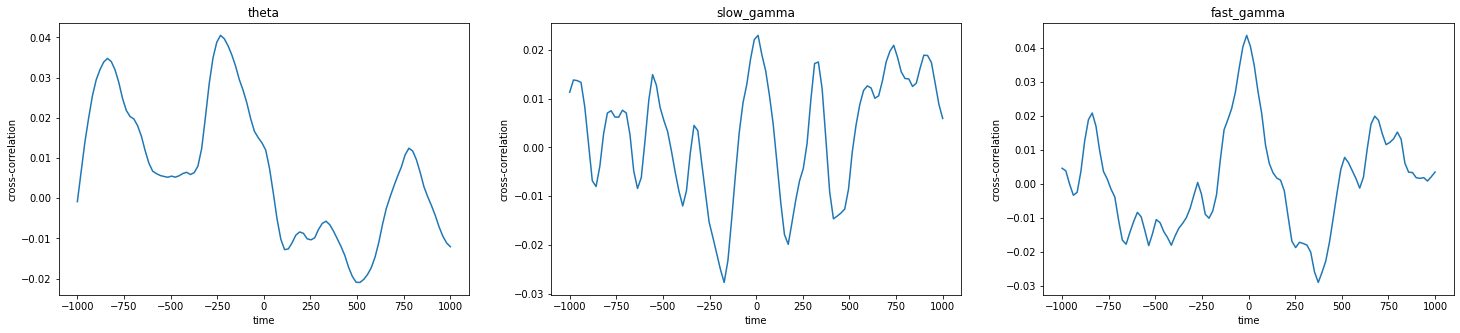

In [96]:
fig, axs = mpl.subplots(1,3, figsize=(25,5))
patients = [46, 53]

signal_len = np.int(fs_downs*1.4)+1
t = np.linspace(-400, 1000, signal_len)
t1 = 0
idx1 = np.where(t == hf.find_nearest(t, t1))[0][0]

for i in range(len(filtering_types)):
    filtering_type = filtering_types[i]
    ampls_pre = []
    ampls_post = []
    all_spikes = []
    
    for j in range(len(patients)):
        patient_id = patients[j]
        df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')
        df_corr_one, _, _, _, _, _, ampl_pre, ampl_post, _, _, _, _, _, _, aa = run_session_corr(df_patient_info, interesting_units[j], interesting_units_dict[j], units_stim_dict[j], units, stims, spiking_resp, pat_ids, patient_id=patient_id, filtering_type=filtering_type)
        ampls_pre.append(ampl_pre)
        ampls_post.append(ampl_post)
        all_spikes.append(aa)
     
    all_spikes = [*all_spikes[0], *all_spikes[1]]
    ampls_post = [*ampls_post[0], *ampls_post[1]]
    t = np.linspace(-1000, 1000, 100) 
    crosscorr_vals = []
    for k in range(len(all_spikes)):
        if not np.isnan(all_spikes[k]).any():
            ampl_post = ampls_post[k]
            ampl_post = ampl_post[idx1:]
            ampl_post = scipy.signal.resample(ampl_post, 100)
            ampl_post = (ampl_post - np.mean(ampl_post)) / np.std(ampl_post, axis=0)
            spikes = (all_spikes[k] - np.mean(all_spikes[k]))/ np.std(all_spikes[k])
            crosscorr_val = np.correlate(spikes, ampl_post, 'same') / min(len(ampl_post), len(spikes))
            crosscorr_vals.append(crosscorr_val)
    crosscorr_vals = np.array(crosscorr_vals)
    crcorr = crosscorr_vals.mean(axis=0)
    axs[i].plot(t, crcorr)
    axs[i].set_title(filtering_type)
    axs[i].set_ylabel('cross-correlation')
    axs[i].set_xlabel('time')
mpl.show()

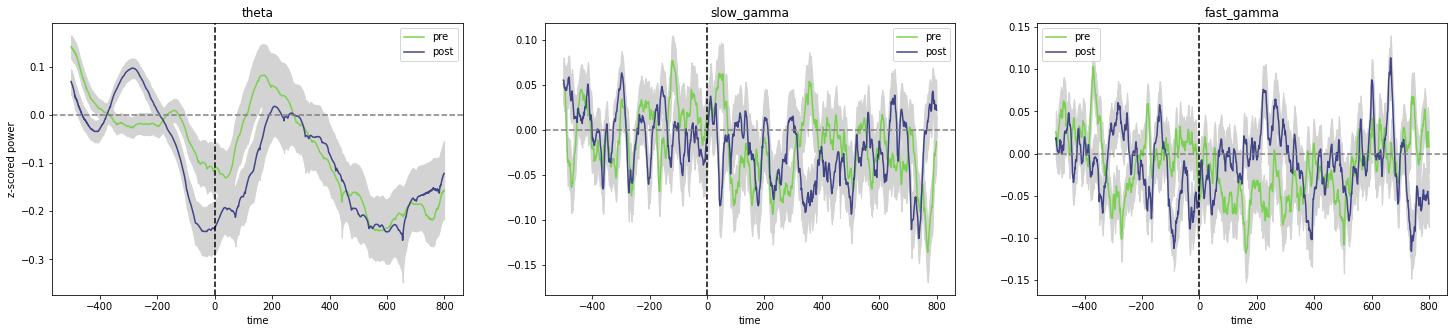

In [53]:
t800 = 800
idx800 = np.where(times == hf.find_nearest(times, t800))[0][0]
fig, axs = mpl.subplots(1,3, figsize=(25,5))
for i in range(len(filtering_types)):
    filtering_type = filtering_types[i]
    units_spikes = []
    units_power = []
    positions = []
    spgrams_pre = []
    spgrams_post = []
    ampls_pre = []
    ampls_post = []

    for j in range(len(patients)):
        patient_id = patients[j]
        df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')
        df_corr_one, units_spikes_one, units_power_one, positions_one, spgrams_pre_one, spgrams_post_one, ampl_pre, ampl_post, units, stims, spiking_resp, pat_ids, crosscorr_val, hist, aa = run_session_corr(df_patient_info, interesting_units[j], interesting_units_dict[j], units_stim_dict[j], units, stims, spiking_resp, pat_ids, patient_id=patient_id, filtering_type=filtering_type)
        df_corr_one = df_corr_one.round(6)
        #df_corr.to_csv(f'{top_dir}/09-corr_lfp_spikes_{patient_id}/df_corr_{filtering_type}.csv')
        units_spikes.append(units_spikes_one)
        units_power.append(units_power_one)
        positions.append(positions_one)
        spgrams_pre.append(spgrams_pre_one)
        spgrams_post.append(spgrams_post_one)
        ampls_pre.append(ampl_pre)
        ampls_post.append(ampl_post)
        
    ampl_pre = [*ampl_pre[0], *ampl_pre[1]]
    ampl_post = [*ampl_post[0], *ampl_post[1]]
    ampl_pre = np.array([item for sublist in ampls_pre for item in sublist])
    ampl_post = np.array([item for sublist in ampls_post for item in sublist])
    std_pre = scipy.stats.sem(ampl_pre[:,:idx800], axis=0)
    std_post = scipy.stats.sem(ampl_post[:,:idx800], axis=0)
    axs[i].plot(times[:idx800], np.mean(ampl_pre[:,:idx800], axis=0), color='#7AD151FF')
    axs[i].fill_between(times[:idx800], np.mean(ampl_pre[:,:idx800], axis=0)+std_pre, np.mean(ampl_pre[:,:idx800], axis=0)-std_pre, color='lightgrey')
    axs[i].plot(times[:idx800], np.mean(ampl_post[:,:idx800], axis=0), color='#414487FF')
    axs[i].fill_between(times[:idx800], np.mean(ampl_post[:,:idx800], axis=0)+std_post, np.mean(ampl_post[:,:idx800], axis=0)-std_post, color='lightgrey')
    axs[i].legend(['pre', 'post'])
    axs[i].set_title(filtering_type)
    if i == 0:
        axs[i].set_ylabel('z-scored power')
    axs[i].set_xlabel('time')
    axs[i].axvline(x=0, color='k', linestyle='--')
    axs[i].axhline(y=0, color='grey', linestyle='--')

mpl.show()
fig.savefig(f'{top_dir}/09-corr_lfp_spikes/mean_hilber_power.jpeg', facecolor='w', transparent=False)

ValueError: v cannot be empty

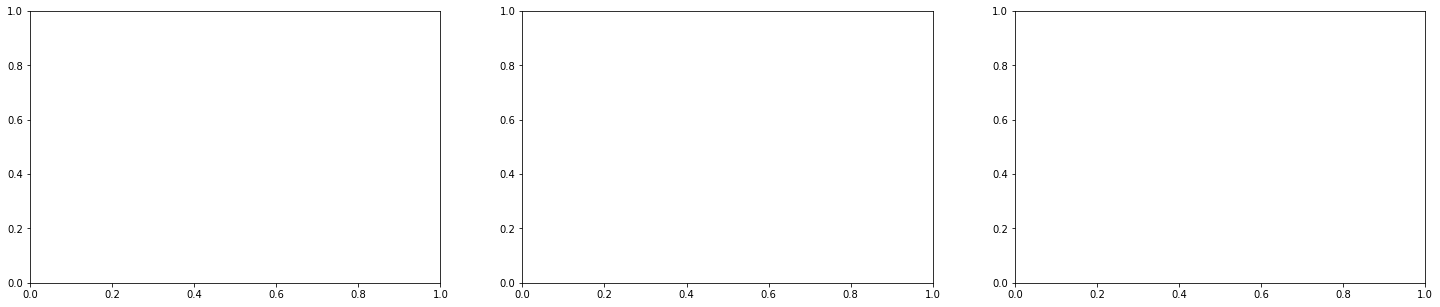

In [74]:
filtering_types = ['theta', 'slow_gamma', 'fast_gamma']
interesting_units_53 = [4, 6, 24, 31]
interesting_units_46 = [1, 7, 8, 16, 18, 26, 29, 31, 33, 37, 42, 45, 46, 59, 67, 68, 69, 88]
interesting_units = [interesting_units_46, interesting_units_53]
interesting_units_46_dict = {1:2, 7:8, 8:8, 16:12, 18:12, 26:26, 29:26, 31:28, 33:29, 37:29, 42:41, 45:42, 46:42, 59:47, 67:52, 68:52, 69:52, 88:67}
interesting_units_53_dict = {4:5, 6:11, 24:45, 31:54}
interesting_units_dict = [interesting_units_46_dict, interesting_units_53_dict]
units_stim_dict_46 = {1:['Paul'], 7:['Alison', 'Paul', 'A Woman'], 8:['Jaws'], 16:['Rachel', 'Paul'], 18:['Black Swan'], 26:['Summer', 'Vance'], 29:['The graduate'], 31:['Tom', 'Summer'], 
                      33:['Alison'], 37:['Rachel', 'A Man'], 42:['Alison', 'Rachel', 'Vance', 'Summer', 'Tom', 'Paul'], 45:['Tom', 'Rachel', 'Summer', 'Tom'],
                      46:['Summer'], 59:['Vance'], 67: ['Titanic'], 68:['Tom'], 69:['Summer'], 88:['Tom', 'Vance']}
units_stim_dict_53 = {4:['Rachel', 'Paul'], 6:['McKenzie'], 24:['Summer'], 31:['Tom']}
units_stim_dict = [units_stim_dict_46, units_stim_dict_53]

top_dir = '/home/anastasia/epiphyte/anastasia/output'
patients = [46, 53]

fig, axs = mpl.subplots(1,3, figsize=(25,5))

for i in range(len(filtering_types)):
    filtering_type = filtering_types[i]
    units_spikes = []
    units_power = []
    positions = []
    spgrams_pre = []
    spgrams_post = []
    ampls_pre = []
    ampls_post = []
    df_corrs = []
    all_spikes_complete = []

    for j in range(len(patients)):
        patient_id = patients[j]
        df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')
        df_corr_one, units_spikes_one, units_power_one, positions_one, spgrams_pre_one, spgrams_post_one, ampl_pre, ampl_post, units, stims, spiking_resp, pat_ids, crosscorr_val, hist, all_spikes = run_session_corr(df_patient_info, interesting_units[j], interesting_units_dict[j], units_stim_dict[j], units, stims, spiking_resp, pat_ids, patient_id=patient_id, filtering_type=filtering_type)
        df_corr_one = df_corr_one.round(6)
        #df_corr.to_csv(f'{top_dir}/09-corr_lfp_spikes_{patient_id}/df_corr_{filtering_type}.csv')
        units_spikes.append(units_spikes_one)
        units_power.append(units_power_one)
        positions.append(positions_one)
        spgrams_pre.append(spgrams_pre_one)
        spgrams_post.append(spgrams_post_one)
        ampls_pre.append(ampl_pre)
        ampls_post.append(ampl_post)
        df_corrs.append(df_corr_one)
        all_spikes_complete.append(all_spikes)
    
    df_corr = df_corrs[0]
    df_corr = df_corr.append(df_corrs[1])
    a = np.array(df_corr.filter(like='rvals'))
    a = a[~np.isnan(a)]
    values, bin_edges = np.histogram(a, bins=50)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (bin_edges[1] - bin_edges[0])
    axs[i].bar(centers, values, color="green",align='center',width=width)
    axs[i].set_title(filtering_type)

mpl.show()
fig.savefig(f'{top_dir}/09-corr_lfp_spikes/corr.jpeg', facecolor='w', transparent=False)


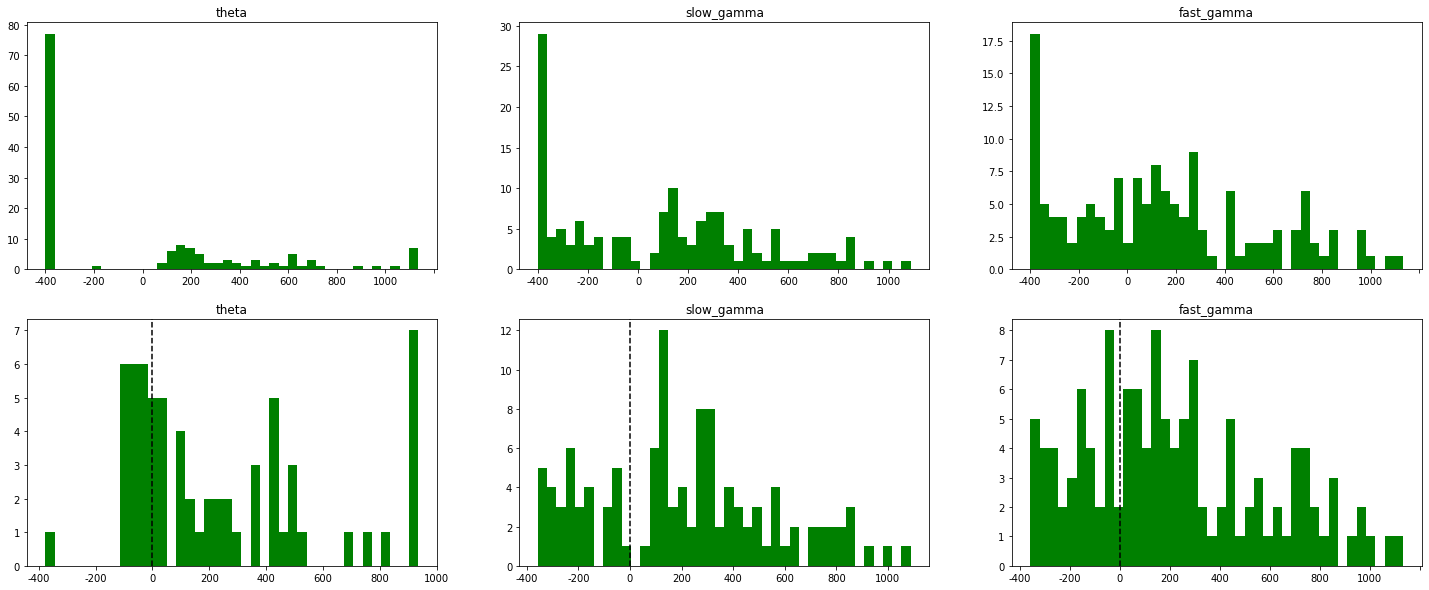

In [135]:
filtering_types = ['theta', 'slow_gamma', 'fast_gamma']
interesting_units_53 = [4, 6, 24, 31]
interesting_units_46 = [1, 7, 8, 16, 18, 26, 29, 31, 33, 37, 42, 45, 46, 59, 67, 68, 69, 88]
interesting_units = [interesting_units_46, interesting_units_53]
interesting_units_46_dict = {1:2, 7:8, 8:8, 16:12, 18:12, 26:26, 29:26, 31:28, 33:29, 37:29, 42:41, 45:42, 46:42, 59:47, 67:52, 68:52, 69:52, 88:67}
interesting_units_53_dict = {4:5, 6:11, 24:45, 31:54}
interesting_units_dict = [interesting_units_46_dict, interesting_units_53_dict]
units_stim_dict_46 = {1:['Paul'], 7:['Alison', 'Paul', 'A Woman'], 8:['Jaws'], 16:['Rachel', 'Paul'], 18:['Black Swan'], 26:['Summer', 'Vance'], 29:['The graduate'], 31:['Tom', 'Summer'], 
                      33:['Alison'], 37:['Rachel', 'A Man'], 42:['Alison', 'Rachel', 'Vance', 'Summer', 'Tom', 'Paul'], 45:['Tom', 'Rachel', 'Summer', 'Tom'],
                      46:['Summer'], 59:['Vance'], 67: ['Titanic'], 68:['Tom'], 69:['Summer'], 88:['Tom', 'Vance']}
units_stim_dict_53 = {4:['Rachel', 'Paul'], 6:['McKenzie'], 24:['Summer'], 31:['Tom']}
units_stim_dict = [units_stim_dict_46, units_stim_dict_53]

top_dir = '/home/anastasia/epiphyte/anastasia/output'
patients = [46, 53]

nbins = 50
fig, axs = mpl.subplots(2,3, figsize=(25,10))
t = np.arange(-400, 1000, nbins)
y_pos = np.arange(len(times))
t = [-600, -400, -200, 0, 200, 400, 600, 800, 1000]

for i in range(len(filtering_types)):
    filtering_type = filtering_types[i]
    units_spikes = []
    units_power = []
    positions = []
    spgrams_pre = []
    spgrams_post = []
    ampls_pre = []
    ampls_post = []
    df_corrs = []

    for j in range(len(patients)):
        patient_id = patients[j]
        df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')
        df_corr_one, units_spikes_one, units_power_one, positions_one, spgrams_pre_one, spgrams_post_one, ampl_pre, ampl_post, units, stims, spiking_resp, pat_ids, crosscorr_val, hist = run_session_corr(df_patient_info, interesting_units[j], interesting_units_dict[j], units_stim_dict[j], units, stims, spiking_resp, pat_ids, patient_id=patient_id, filtering_type=filtering_type)
        df_corr_one = df_corr_one.round(6)
        #df_corr.to_csv(f'{top_dir}/09-corr_lfp_spikes_{patient_id}/df_corr_{filtering_type}.csv')
        units_spikes.append(units_spikes_one)
        units_power.append(units_power_one)
        positions.append(positions_one)
        spgrams_pre.append(spgrams_pre_one)
        spgrams_post.append(spgrams_post_one)
        ampls_pre.append(ampl_pre)
        ampls_post.append(ampl_post)
        df_corrs.append(df_corr_one)
        #select here more responsive
    
    positions = np.array([item for sublist in positions for item in sublist])
    
    values, bin_edges = np.histogram(positions, bins=40)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (bin_edges[1] - bin_edges[0])
    axs[0,i].bar(centers, values, color="green",align='center',width=width)
    axs[0,i].set_title(filtering_type)
    axs[0,i].set_xticklabels(t)
    
    bin_min= bin_edges[np.where(values == np.max(values))]
    bin_max= bin_min + width
    new_val = positions[(positions<bin_min) | (positions>bin_max)]

    values, bin_edges = np.histogram(new_val, bins=40)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (bin_edges[1] - bin_edges[0])
    axs[1,i].bar(centers, values, color="green",align='center',width=width)
    axs[1,i].set_title(filtering_type)
    #axs[1,i].set_xticks(t)
    axs[1,i].set_xticklabels(t)
    if i == 0:
        axs[1,i].axvline(x=t[6], color='k', linestyle='--')
    else:
        axs[1,i].axvline(x=t[5], color='k', linestyle='--')
    

mpl.show()
fig.savefig(f'{top_dir}/09-corr_lfp_spikes/positions.jpeg', facecolor='w', transparent=False)

2
(1099,)
2
(1099,)
2
(1099,)


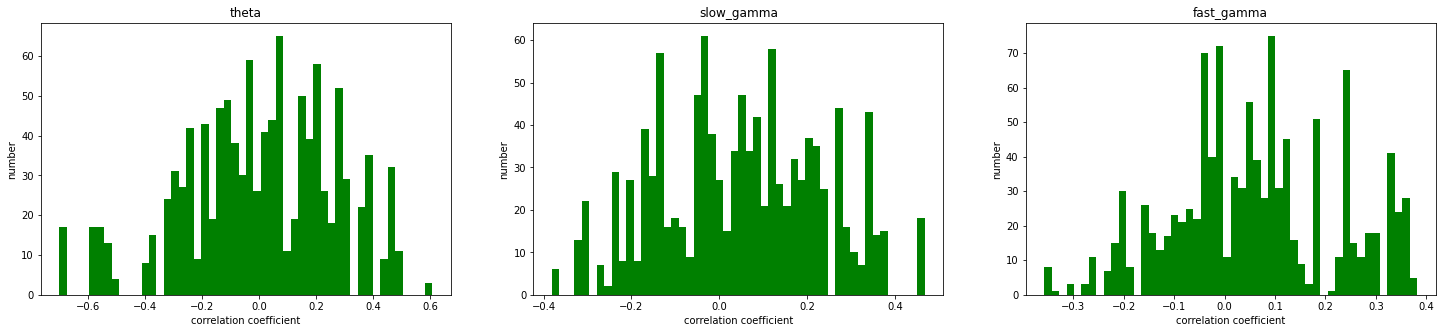

In [177]:
filtering_types = ['theta', 'slow_gamma', 'fast_gamma']
interesting_units_53 = [4, 6, 24, 31]
interesting_units_46 = [1, 7, 8, 16, 18, 26, 29, 31, 33, 37, 42, 45, 46, 59, 67, 68, 69, 88]
interesting_units = [interesting_units_46, interesting_units_53]
interesting_units_46_dict = {1:2, 7:8, 8:8, 16:12, 18:12, 26:26, 29:26, 31:28, 33:29, 37:29, 42:41, 45:42, 46:42, 59:47, 67:52, 68:52, 69:52, 88:67}
interesting_units_53_dict = {4:5, 6:11, 24:45, 31:54}
interesting_units_dict = [interesting_units_46_dict, interesting_units_53_dict]
units_stim_dict_46 = {1:['Paul'], 7:['Alison', 'Paul', 'A Woman'], 8:['Jaws'], 16:['Rachel', 'Paul'], 18:['Black Swan'], 26:['Summer', 'Vance'], 29:['The graduate'], 31:['Tom', 'Summer'], 
                      33:['Alison'], 37:['Rachel', 'A Man'], 42:['Alison', 'Rachel', 'Vance', 'Summer', 'Tom', 'Paul'], 45:['Tom', 'Rachel', 'Summer', 'Tom'],
                      46:['Summer'], 59:['Vance'], 67: ['Titanic'], 68:['Tom'], 69:['Summer'], 88:['Tom', 'Vance']}
units_stim_dict_53 = {4:['Rachel', 'Paul'], 6:['McKenzie'], 24:['Summer'], 31:['Tom']}
units_stim_dict = [units_stim_dict_46, units_stim_dict_53]

top_dir = '/home/anastasia/epiphyte/anastasia/output'
patients = [46, 53]

fig, axs = mpl.subplots(1,3, figsize=(25,5))

for i in range(len(filtering_types)):
    filtering_type = filtering_types[i]
    units_spikes = []
    units_power = []
    positions = []
    spgrams_pre = []
    spgrams_post = []
    ampls_pre = []
    ampls_post = []
    df_corrs = []
    all_spikes_complete = []

    for j in range(len(patients)):
        patient_id = patients[j]
        df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')
        df_corr_one, units_spikes_one, units_power_one, positions_one, spgrams_pre_one, spgrams_post_one, ampl_pre, ampl_post, units, stims, spiking_resp, pat_ids, crosscorr_val, hist, all_spikes = run_session_corr(df_patient_info, interesting_units[j], interesting_units_dict[j], units_stim_dict[j], units, stims, spiking_resp, pat_ids, patient_id=patient_id, filtering_type=filtering_type)
        df_corr_one = df_corr_one.round(6)
        #df_corr.to_csv(f'{top_dir}/09-corr_lfp_spikes_{patient_id}/df_corr_{filtering_type}.csv')
        units_spikes.append(units_spikes_one)
        units_power.append(units_power_one)
        positions.append(positions_one)
        spgrams_pre.append(spgrams_pre_one)
        spgrams_post.append(spgrams_post_one)
        ampls_pre.append(ampl_pre)
        ampls_post.append(ampl_post)
        df_corrs.append(df_corr_one)
        all_spikes_complete.append(all_spikes)
    
    print(len(df_corrs))
    df_corr = df_corrs[0]
    df_corr = df_corr.append(df_corrs[1])
    a = np.array(df_corr.filter(like='rvals'))
    a = a[~np.isnan(a)]
    print(a.shape)
    values, bin_edges = np.histogram(a, bins=50)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (bin_edges[1] - bin_edges[0])
    axs[i].bar(centers, values, color="green",align='center',width=width)
    axs[i].set_title(filtering_type)
    axs[i].set_ylabel('number')
    axs[i].set_xlabel('correlation coefficient')
    del df_corr

mpl.show()
fig.savefig(f'{top_dir}/09-corr_lfp_spikes/corr.jpeg', facecolor='w', transparent=False)


In [172]:
df_corr['rvals_7_unit-7']

NameError: name 'df_corr' is not defined

In [176]:
a.shape

(1099,)

In [166]:
a

array([ 0.052392,  0.052392,  0.052392, ..., -0.039364, -0.097935,
        0.052727])

In [53]:
"""
Functions for plotting the screening results. 
Adapted from Johannes Niediek's original standalone code to interface withe database 
"""

import warnings
import scipy.signal
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as mpl
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec

# local imports
from database.db_setup import *

from visualization.scr_utils import *
import analysis.stats_code.compute_pvalues as cp

warnings.filterwarnings("ignore")

import utils.helper_func as hf

# constants 

EMPTY = np.array([])
OUTFOLDER = 'pvalues'

PVAL_CUTOFF = .1
MIN_ACTIVE_TRIALS = 3

FIGSIZE = (12, 12)
T_PRE = 1000
T_POST = 2000
HIST_BIN_WIDTH = 50
HIST_BINS = np.arange(-T_PRE, T_POST + 1, HIST_BIN_WIDTH)

POSITIONS = ('pre', 'post')
COLORS = ('blue', 'green')

DPI = 200

fs = 32768
up = 1
down=32
fs_downs = (up/down)*fs
signal_len = np.int(fs_downs*1.5)+1
times = np.linspace(-0.5, 1, signal_len)
times = times*1000
t400 = -400
t1 = 0
t2 = 1000
idx400 = np.where(times == hf.find_nearest(times, t400))[0][0]
idx1 = np.where(times == hf.find_nearest(times, t1))[0][0]
idx2 = np.where(times == hf.find_nearest(times, t2))[0][0]

def make_one_lfp_spike_correlation(sp_times, event_data, pvalues, amplitude_envelope_pre, amplitude_envelope_post, std_pre, std_post):
    
    sep = .2
    hist_max = 0
    time_data = []
    color_data = []
    hist_data = []
    
    events = event_data.loc[event_data.position == 'post', 'time'].values
    for event in events:
        idx_sp = (sp_times >= event - T_PRE) & (sp_times <= event + T_POST)
        if idx_sp.any():
            temp = sp_times[idx_sp] - event
            time_data.append(temp)
            t_hist, _ = np.histogram(temp, HIST_BINS)   
            hist_data.append(t_hist * 1000 / HIST_BIN_WIDTH)
        else:
            time_data.append([-2*T_PRE])   # hack of eventplot
            
    if len(hist_data):
        hist = np.vstack(hist_data).mean(0)
        
              
    return hist[10:41]

            
def run_session_corr(df_patient_info, interesting_units, interesting_units_dict, units_stim_dict, patient_id, filtering_type):
    """
    load stimulus frame and channel list for one session
    """  
    folder=f'05-Hilbert_transform_{patient_id}'
    spgram_data = f'04-spectrogram_wavelet_{patient_id}'
    norm_type = 'zscore'
    session_nr = get_session_info(patient_id)
    
    assert isinstance(session_nr, int), "More than one session for patient {}. Code currently not set up for automatically running multiple sessions from a single patient.".format(patient_id)
    
    position, stim_id, filename, stim_name, is_500_days, paradigm, time = get_screening_data(patient_id, session_nr)
    frame = cp.make_dataframe(position, stim_id, filename, stim_name, is_500_days, paradigm, time)
    
    stim_data = {}
    stim_nums = frame.stim_num.unique()

    for stim_num in stim_nums:
        meta = frame.loc[frame.stim_num == stim_num, :].iloc[0]
        stim_fname = meta["filename"]
        stim_data[stim_fname] = (stim_num,
                                meta["stim_name"],
                                meta["paradigm"],
                                mpl.imread(os.path.join(PATH_TO_IMAGES, stim_fname))) ## read image file into an array

    all_channels = get_cscs_for_patient(patient_id, session_nr)
    
    df_corr_all = pd.DataFrame()
    units_spikes = []
    units_power = []
    positions = []
    ampl_pre = []
    ampl_post = []
    all_hists = []
    stim_numbers = []
    image_names = []
    rvals = []
    pvals = []
    parts_spikes = []
    parts_power = []
    spgrams_pre = []
    spgrams_post = []
    crosscorr_vals = []
    all_spikes = []
    hists = []
    for unit in interesting_units:
        #print("Running unit {}...".format(unit))
        ch = interesting_units_dict[unit]
        ch_site = df_patient_info.loc[ch-1,'recording_site']
        df_corr = pd.DataFrame()

        spikes = get_spiking_activity(patient_id, session_nr, unit)

        stim_index, eventtimes = get_scr_eventtimes(patient_id, session_nr)

        region = get_brain_region(patient_id, unit)
        unit_type = get_unit_type(patient_id, session_nr, unit)

        unit_pvals = get_scr_stats_as_df(patient_id, session_nr, unit)

        times = spikes
        save_unit = False
        num_stimuli = len(np.unique(frame["filename"]))

        if num_stimuli == 42:
            img_order = IMAGE_ORDER_ALL
        elif num_stimuli == 35:
            img_order = IMAGE_ORDER_NO_TEXT
        else: 
            raise Exception("Irregular number of stimuli for patient.")

        for i_row, row in enumerate(img_order):
            for i_col, img_fname in enumerate(row):
                stim_num, stim_name, paradigm, image = stim_data[img_fname]
                stim_numbers.append(stim_num)
                image_names.append(stim_name)

                if stim_name == '???':
                    ampl_envelope_pre = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_unknown_amplitude_envelope_{norm_type}_pre.npy')
                    ampl_envelope_post = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_unknown_amplitude_envelope_{norm_type}_post.npy')
                    spgram_pre = np.load(f'{top_dir}/{spgram_data}/spectrograms/normalized/{norm_type}/CSC{ch}_{ch_site}_{stim_num}_unknown_pre_{norm_type}.npy')
                    spgram_post = np.load(f'{top_dir}/{spgram_data}/spectrograms/normalized/{norm_type}/CSC{ch}_{ch_site}_{stim_num}_unknown_post_{norm_type}.npy')
                else:
                    ampl_envelope_pre = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_{stim_name}_amplitude_envelope_{norm_type}_pre.npy')
                    ampl_envelope_post = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_{stim_name}_amplitude_envelope_{norm_type}_post.npy')
                    spgram_pre = np.load(f'{top_dir}/{spgram_data}/spectrograms/normalized/{norm_type}/CSC{ch}_{ch_site}_{stim_num}_{stim_name}_pre_{norm_type}.npy')
                    spgram_post = np.load(f'{top_dir}/{spgram_data}/spectrograms/normalized/{norm_type}/CSC{ch}_{ch_site}_{stim_num}_{stim_name}_post_{norm_type}.npy')
                    
                std_pre = np.std(ampl_envelope_pre)
                std_post = np.std(ampl_envelope_post)            
                
                if stim_name in units_stim_dict[unit]:
                    amplitude_envelope_pre = np.mean(ampl_envelope_pre, axis=0)
                    amplitude_envelope_post = np.mean(ampl_envelope_post, axis=0)
                    ampl_pre.append(amplitude_envelope_pre[idx1:idx2])
                    ampl_post.append(amplitude_envelope_post[idx1:idx2])
                    position = np.argmax(np.abs(amplitude_envelope_post) > 1)
                    amplitude_envelope_pre = amplitude_envelope_pre[idx1:idx2]
                    amplitude_envelope_post = amplitude_envelope_post[idx1:idx2]
                    #position = np.abs(amplitude_envelope_post - np.mean(amplitude_envelope_post)) > 2 #bc zscore is already on the scale of std
                    positions.append(position)
                    spgrams_pre.append(spgram_pre)
                    spgrams_post.append(spgram_post)

                    #DOWNSAMPLE
                    amplitude_envelope_pre = scipy.signal.resample(amplitude_envelope_pre, 100)
                    amplitude_envelope_post = scipy.signal.resample(amplitude_envelope_post, 100)
                
                    aa = make_one_lfp_spike_correlation(times, frame.loc[frame.stim_num == stim_num, ['position', 'time']],
                        unit_pvals.loc[unit_pvals.stim_num == stim_num, :], amplitude_envelope_pre, amplitude_envelope_post, std_pre, std_post)
                    all_spikes.append(aa)
                    
                else:
                    rval, pval, part_spikes, part_power, crosscorr_val, hist = float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan')
                rvals.append(rval)
                pvals.append(pval)
                parts_spikes.append(part_spikes)
                parts_power.append(part_power)
                crosscorr_vals.append(crosscorr_val)
                hists.append(hist)
        
        df_corr[f'rvals_{unit}'] = rvals
        df_corr[f'pvals_{unit}'] = pvals
        
        df_corr = df_corr.add_suffix(f'_unit-{unit}')
        df_corr_all = pd.concat([df_corr_all, df_corr], axis=1)
        units_spikes.append(parts_spikes)
        units_power.append(parts_power)
        
    df_corr_all.insert(loc=0, column='stim_numbers', value=stim_numbers)
    df_corr_all.insert(loc=0, column='image_names', value=image_names)
    
    return df_corr_all, units_spikes, units_power, positions, spgrams_pre, spgrams_post, ampl_pre, ampl_post, crosscorr_vals, hists, all_spikes


Text(0, 0.5, 'firing rate')

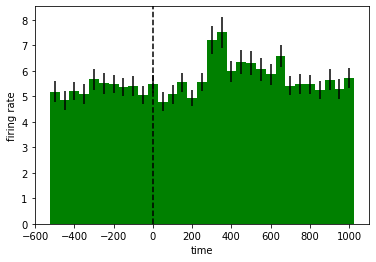

In [54]:
all_spikes_complete = []
patients = [46, 53]

filtering_type = 'theta'
for j in range(len(patients)):
    patient_id = patients[j]
    df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')
    df_corr_one, units_spikes_one, units_power_one, positions_one, spgrams_pre_one, spgrams_post_one, ampl_pre, ampl_post, crosscorr_val, hist, all_spikes = run_session_corr(df_patient_info, interesting_units[j], interesting_units_dict[j], units_stim_dict[j], patient_id=patient_id, filtering_type=filtering_type)
    df_corr_one = df_corr_one.round(6)
    all_spikes_complete.append(all_spikes)

all_spikes_complete = [*all_spikes_complete[0], *all_spikes_complete[1]]
HIST_BIN_WIDTH = 50
HIST_BINS = np.arange(-500, 1000 + 1, HIST_BIN_WIDTH)
hist = np.vstack(all_spikes_complete).mean(0)
std = scipy.stats.sem(all_spikes_complete, axis=0)
all_spikes_complete = np.array(all_spikes_complete)
#bin_stds, bin_edges, binnumber = stats.binned_statistic(all_spikes_complete.T, all_spikes_complete.T, statistic='std', bins=HIST_BINS)
mpl.bar(HIST_BINS, hist, width=HIST_BIN_WIDTH, yerr=std, color='green', lw=0)
#mpl.bar(HIST_BINS, hist, width=HIST_BIN_WIDTH, color='lightgreen', lw=0)
#mpl.hlines(bin_stds, bin_edges[:-1], bin_edges[1:], colors='black', lw=2, label='binned statistic of data')
mpl.axvline(x=0, color='k', linestyle='--')
mpl.xlabel('time')
mpl.ylabel('firing rate')
#y, bin_edges = np.histogram(hist, bins=HIST_BINS)
#bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
#mpl.errorbar(bin_centers,y,yerr = std,marker = '.',)

#fig.savefig(f'{top_dir}/09-corr_lfp_spikes/corr.jpeg', facecolor='w', transparent=False)

In [36]:
std = np.std(all_spikes_complete, axis=0)

In [40]:
y, bin_edges = np.histogram(hist, bins=HIST_BINS)

In [48]:
y

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 31,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

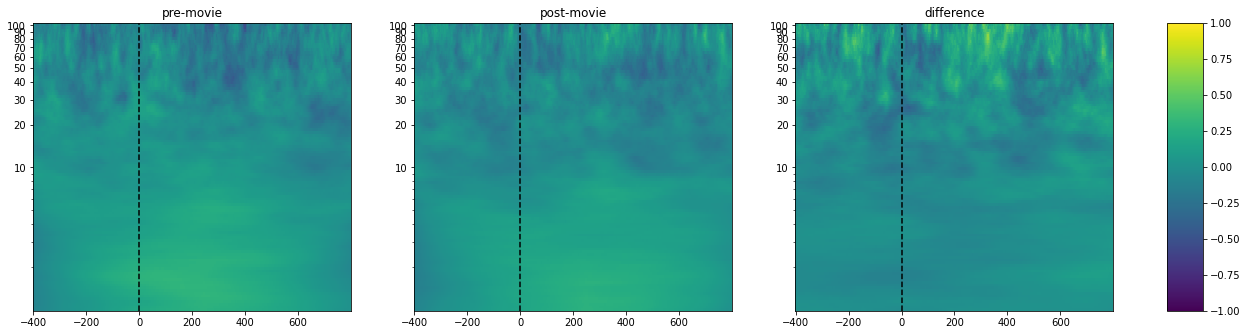

<Figure size 432x288 with 0 Axes>

In [137]:
spgrams_pre = [*spgrams_pre[0], *spgrams_pre[1]]
spgrams_post = [*spgrams_post[0], *spgrams_post[1]]
spgram_pre = np.mean(np.mean(np.array(spgrams_pre), axis=0), axis=0)
spgram_post = np.mean(np.mean(np.array(spgrams_post), axis=0), axis=0)

spgram_data = f'04-spectrogram_wavelet_{patient_id}'
freq = np.load(f'{top_dir}/{spgram_data}/spectrograms/freq.npy')
t = np.load(f'{top_dir}/{spgram_data}/spectrograms/times.npy')
idx1 = np.where(t == hf.find_nearest(t, -400))[0][0]
idx2 = np.where(t == hf.find_nearest(t, 800))[0][0]
idx0 = np.where(t == hf.find_nearest(t, 0))[0][0]
idx = np.where(freq == hf.find_nearest(freq, 100))[0][0]
freq = freq[0:idx+1]
fig, (ax1, ax2, ax3) = mpl.subplots(1, 3, figsize=(25,5))
mpl.figure()
im = ax1.pcolormesh(t[idx1:idx2], freq, spgram_pre[:idx+1,idx1:idx2], shading='auto', cmap='viridis', vmin=-1, vmax=1)
ax1.set_title('pre-movie')
ax1.axvline(x=t[512], color='k', linestyle='--')
ax1.set_yscale('log')
ax1.set_yticks([10,20,30,40,50,60,70,80,90,100])
ax1.set_yticklabels([10,20,30,40,50,60,70,80,90,100])
#cbar = fig.colorbar(im)
im = ax2.pcolormesh(t[idx1:idx2], freq, spgram_post[:idx+1,idx1:idx2], shading='auto', cmap='viridis', vmin=-1, vmax=1)
ax2.set_title('post-movie')
ax2.axvline(x=t[512], color='k', linestyle='--')
ax2.set_yscale('log')
ax2.set_yticks([10,20,30,40,50,60,70,80,90,100])
ax2.set_yticklabels([10,20,30,40,50,60,70,80,90,100])
im = ax3.pcolormesh(t[idx1:idx2], freq, spgram_post[:idx+1,idx1:idx2]-spgram_pre[:idx+1,idx1:idx2], shading='auto', cmap='viridis', vmin=-1, vmax=1)
ax3.set_title('difference')
ax3.axvline(x=t[512], color='k', linestyle='--')
ax3.set_yscale('log')
ax3.set_yticks([10,20,30,40,50,60,70,80,90,100])
ax3.set_yticklabels([10,20,30,40,50,60,70,80,90,100])
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.2, right=0.8, wspace=0.2, hspace=0.02)
mpl.show()
fig.savefig(f'{top_dir}/09-corr_lfp_spikes/mean_spectrogram.jpeg', facecolor='w', transparent=False)

In [6]:
"""
Functions for plotting the screening results. 
Adapted from Johannes Niediek's original standalone code to interface withe database 
"""

import warnings
import scipy.signal
import numpy as np
import matplotlib.pyplot as mpl
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec

# local imports
from database.db_setup import *

from visualization.scr_utils import *
import analysis.stats_code.compute_pvalues as cp

warnings.filterwarnings("ignore")

# constants 

EMPTY = np.array([])
OUTFOLDER = 'pvalues'

PVAL_CUTOFF = .1
MIN_ACTIVE_TRIALS = 3

FIGSIZE = (12, 12)
T_PRE = 1000
T_POST = 2000
HIST_BIN_WIDTH = 10
HIST_BINS = np.arange(-T_PRE, T_POST + 1, HIST_BIN_WIDTH)

POSITIONS = ('pre', 'post')
COLORS = ('blue', 'green')

DPI = 200


def make_one_lfp_spike_crosscorrelation(sp_times, event_data, pvalues, amplitude_envelope_pre, amplitude_envelope_post, std_pre, std_post):
    
    sep = .2
    hist_max = 0
    time_data = []
    color_data = []
    hist_data = []
    
    events = event_data.loc[event_data.position == 'post', 'time'].values
    for event in events:
        idx_sp = (sp_times >= event - T_PRE) & (sp_times <= event + T_POST)
        if idx_sp.any():
            temp = sp_times[idx_sp] - event

            time_data.append(temp)
            t_hist, _ = np.histogram(temp, HIST_BINS)   

            hist_data.append(t_hist * 1000 / HIST_BIN_WIDTH)
        else:
            time_data.append([-2*T_PRE])   # hack of eventplot

    if len(hist_data):
        hist = np.vstack(hist_data).mean(0) 
        firing_rate = t_hist * 1000 / HIST_BIN_WIDTH
        aa = firing_rate[100:200]
        gauss_window = scipy.signal.windows.gaussian(5, std=2)
        aa = np.convolve(aa, gauss_window, mode='same')
        crosscorr_val = np.correlate(amplitude_envelope_post, aa, 'same')
    else: 
        crosscorr_val = float('nan')
           
    return crosscorr_val


def crosscorr_one_unit(stim_frame, spikes, unit_pvals, stim_data, ch, ch_site, filtering_type):
    """
    stim_data is a filename -> (a, b, c, d) dictionary, where
    a: stim_num
    b: stim_name
    c: paradigm
    d: image
    """

    all_hists = []
    stim_numbers = []
    image_names = []
    rvals = []
    pvals = []
    times = spikes
    save_unit = False
    folder=f'05-Hilbert_transform_{patient_id}'
    norm_type = 'zscore'
    num_stimuli = len(np.unique(stim_frame["filename"]))
    
    if num_stimuli == 42:
        img_order = IMAGE_ORDER_ALL
    elif num_stimuli == 35:
        img_order = IMAGE_ORDER_NO_TEXT
    else: 
        raise Exception("Irregular number of stimuli for patient.")
    
    for i_row, row in enumerate(img_order):
        for i_col, img_fname in enumerate(row):
            stim_num, stim_name, paradigm, image = stim_data[img_fname]
            stim_numbers.append(stim_num)
            image_names.append(stim_name)

            if stim_name == '???':
                ampl_envelope_pre = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_unknown_amplitude_envelope_{norm_type}_pre.npy')
                ampl_envelope_post = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_unknown_amplitude_envelope_{norm_type}_post.npy')
            else:
                ampl_envelope_pre = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_{stim_name}_amplitude_envelope_{norm_type}_pre.npy')
                ampl_envelope_post = np.load(f'{top_dir}/{folder}/{filtering_type}/power/{norm_type}/CSC{ch}_{ch_site}/CSC{ch}_{ch_site}_{stim_num}_{stim_name}_amplitude_envelope_{norm_type}_post.npy')
            std_pre = np.std(ampl_envelope_pre,axis=0)
            std_post = np.std(ampl_envelope_post,axis=0)            
            
            amplitude_envelope_pre = np.mean(ampl_envelope_pre, axis=0)
            amplitude_envelope_post = np.mean(ampl_envelope_post, axis=0)
            amplitude_envelope_pre = amplitude_envelope_pre[500:1000]
            amplitude_envelope_post = amplitude_envelope_post[500:1000]

            #DOWNSAMPLE
            amplitude_envelope_pre = scipy.signal.resample(amplitude_envelope_pre, 100)
            amplitude_envelope_post = scipy.signal.resample(amplitude_envelope_post, 100)
            
            crosscorr_val = make_one_lfp_spike_crosscorrelation(times, stim_frame.loc[stim_frame.stim_num == stim_num, ['position', 'time']],
                    unit_pvals.loc[unit_pvals.stim_num == stim_num, :], amplitude_envelope_pre, amplitude_envelope_post, std_pre, std_post)
            rvals.append(crosscorr_val)
            
    return stim_numbers, image_names, rvals


def run_one_channel_corr(frame, channel, unit, ch_site, patient_id, session_nr, stim_data, filtering_type):
    """
    load the pvalues and units for one channel, one sorting, and iterate over the units
    """
    
    # get all units from a single channel
    #channel_units = get_unit_ids_in_channel(patient_id, session_nr, channel)
    
    df_corr = pd.DataFrame()
    
    #for unit in channel_units:
    spikes = get_spiking_activity(patient_id, session_nr, unit)

    stim_index, eventtimes = get_scr_eventtimes(patient_id, session_nr)

    region = get_brain_region(patient_id, unit)
    unit_type = get_unit_type(patient_id, session_nr, unit)

    unit_pvals = get_scr_stats_as_df(patient_id, session_nr, unit)

    stim_numbers, image_names, rvals = crosscorr_one_unit(frame, spikes, unit_pvals, stim_data, channel, ch_site, filtering_type)
    df_corr[f'rvals_{unit}'] = rvals
    
    return df_corr, stim_numbers, image_names

            
def run_session_corr(df_patient_info, interesting_units, interesting_units_dict, patient_id, filtering_type):
    """
    load stimulus frame and channel list for one session
    """  
    session_nr = get_session_info(patient_id)
    
    assert isinstance(session_nr, int), "More than one session for patient {}. Code currently not set up for automatically running multiple sessions from a single patient.".format(patient_id)
    
    position, stim_id, filename, stim_name, is_500_days, paradigm, time = get_screening_data(patient_id, session_nr)
    frame = cp.make_dataframe(position, stim_id, filename, stim_name, is_500_days, paradigm, time)

    stim_data = {}
    stim_nums = frame.stim_num.unique()

    for stim_num in stim_nums:
        meta = frame.loc[frame.stim_num == stim_num, :].iloc[0]
        stim_fname = meta["filename"]
        stim_data[stim_fname] = (stim_num,
                                meta["stim_name"],
                                meta["paradigm"],
                                mpl.imread(os.path.join(PATH_TO_IMAGES, stim_fname))) ## read image file into an array

    all_channels = get_cscs_for_patient(patient_id, session_nr)
    
    df_corr_all = pd.DataFrame()
    #for channel in all_channels:
    for unit in interesting_units:
        print("Running unit {}...".format(unit))
        channel = interesting_units_dict[unit]
        ch_site = df_patient_info.loc[channel-1,'recording_site']
        df_corr, stim_numbers, image_names = run_one_channel_corr(frame, channel, unit, ch_site, patient_id, session_nr, stim_data, filtering_type)
        df_corr = df_corr.add_suffix(f'_unit-{unit}')
        #print(df_corr)
        #df_corr = df_corr.astype('int64', errors='ignore') 
        df_corr_all = pd.concat([df_corr_all, df_corr], axis=1)
    
    df_corr_all.insert(loc=0, column='stim_numbers', value=stim_numbers)
    df_corr_all.insert(loc=0, column='image_names', value=image_names)
    return df_corr_all


TypeError: run_session_corr() got multiple values for argument 'patient_id'

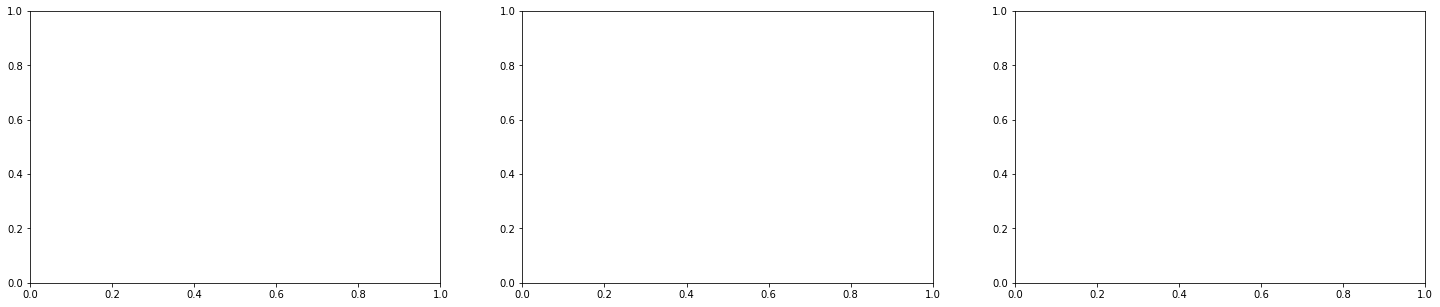

In [66]:
filtering_types = ['theta', 'slow_gamma', 'fast_gamma']
interesting_units_53 = [4, 6, 24, 31]
interesting_units_46 = [1, 7, 8, 16, 18, 26, 29, 31, 33, 37, 42, 45, 46, 59, 67, 68, 69, 88]
interesting_units = [interesting_units_46, interesting_units_53]
interesting_units_46_dict = {1:2, 7:8, 8:8, 16:12, 18:12, 26:26, 29:26, 31:28, 33:29, 37:29, 42:41, 45:42, 46:42, 59:47, 67:52, 68:52, 69:52, 88:67}
interesting_units_53_dict = {4:5, 6:11, 24:45, 31:54}
interesting_units_dict = [interesting_units_46_dict, interesting_units_53_dict]
units_stim_dict_46 = {1:['Paul'], 7:['Alison', 'Paul', 'A Woman'], 8:['Jaws'], 16:['Rachel', 'Paul'], 18:['Black Swan'], 26:['Summer', 'Vance'], 29:['The graduate'], 31:['Tom', 'Summer'], 
                      33:['Alison'], 37:['Rachel', 'A Man'], 42:['Alison', 'Rachel', 'Vance', 'Summer', 'Tom', 'Paul'], 45:['Tom', 'Rachel', 'Summer', 'Tom'],
                      46:['Summer'], 59:['Vance'], 67: ['Titanic'], 68:['Tom'], 69:['Summer'], 88:['Tom', 'Vance']}
units_stim_dict_53 = {4:['Rachel', 'Paul'], 6:['McKenzie'], 24:['Summer'], 31:['Tom']}
units_stim_dict = [units_stim_dict_46, units_stim_dict_53]

sig_units_46 = [16, 31, 33, 42, 45, 46, 67, 68, 69, 88]
sig_units_53 = [24]
sig_units = [sig_units_46, sig_units_53]
sig_units_stim_dict_46 = {16:['Rachel'], 31:['Summer'], 33:['Alison'], 42:['Summer', 'Tom', 'Paul', 'Rachel'], 45:['Summer', 'Tom', 'Rachel'], 46:['Summer'], 67:['Titanic'], 68:['Tom'], 69:['Summer'], 88:['Tom']}
sig_units_stim_dict_53 = {24:['Summer']}
sig_units_stim_dict = [sig_units_stim_dict_46, sig_units_stim_dict_53]

top_dir = '/home/anastasia/epiphyte/anastasia/output'
patients = [46, 53]
fig, axs = mpl.subplots(1,3, figsize=(25,5))

for i in range(len(filtering_types)):
    filtering_type = filtering_types[i]
    units_spikes = []
    units_power = []
    positions = []
    spgrams_pre = []
    spgrams_post = []
    ampls_pre = []
    ampls_post = []
    units = []
    stims = []
    spiking_resp = []
    pat_ids = []
    sig_units_spikes = []
    sig_units_power = []
    
    for j in range(len(patients)):
        patient_id = patients[j]
        df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')

        df_corr_one, units_spikes_one, units_power_one, positions_one, spgrams_pre_one, spgrams_post_one, ampl_pre, ampl_post, units, stims, spiking_resp, pat_ids = run_session_corr(df_patient_info, interesting_units[j], interesting_units_dict[j], units_stim_dict[j], units, stims, spiking_resp, pat_ids, patient_id=patient_id, filtering_type=filtering_type)
        df_corr_one = df_corr_one.round(6)
        #df_corr.to_csv(f'{top_dir}/09-corr_lfp_spikes_{patient_id}/df_corr_{filtering_type}.csv')
        units_spikes.append(units_spikes_one)
        units_power.append(units_power_one)
        positions.append(positions_one)
        spgrams_pre.append(spgrams_pre_one)
        spgrams_post.append(spgrams_post_one)
        ampls_pre.append(ampl_pre)
        ampls_post.append(ampl_post)
        
        #select here more responsive
        df_corr_one, units_spikes_one, units_power_one, positions_one, spgrams_pre_one, spgrams_post_one, ampl_pre, ampl_post, units, stims, spiking_resp, pat_ids = run_session_corr(df_patient_info, sig_units[j], interesting_units_dict[j], sig_units_stim_dict[j], units, stims, spiking_resp, pat_ids, patient_id=patient_id, filtering_type=filtering_type)
        sig_units_spikes.append(units_spikes_one)
        sig_units_power.append(units_power_one)
        
    units_spikes = [item for sublist in units_spikes for item in sublist]
    units_power = [item for sublist in units_power for item in sublist]
    sig_units_spikes = [item for sublist in sig_units_spikes for item in sublist]
    sig_units_power = [item for sublist in sig_units_power for item in sublist]
    
    idx = np.isfinite(units_spikes) & np.isfinite(units_power)
    m, b = np.polyfit(np.array(units_spikes)[idx], np.array(units_power)[idx], 1)
    axs[i].scatter(units_spikes, units_power)
    axs[i].set_xlabel('mean spike rate 200-700 ms')
    axs[i].set_ylabel(f'mean {filtering_type} power 200-700 ms')
    axs[i].plot(np.array(units_spikes)[idx], m*np.array(units_spikes)[idx] + b, linestyle='dashed')
    
    idx_sig = np.isfinite(sig_units_spikes) & np.isfinite(sig_units_power)
    m, b = np.polyfit(np.array(sig_units_spikes)[idx_sig], np.array(sig_units_power)[idx_sig], 1)
    axs[i].scatter(sig_units_spikes, sig_units_power, color='green')
    #mpl.xlabel('mean spike rate 200-700 ms')
    #mpl.ylabel(f'mean {filtering_type} power 200-700 ms')
    axs[i].plot(np.array(sig_units_spikes)[idx_sig], m*np.array(sig_units_spikes)[idx_sig] + b, linestyle='dashed', color='green')
mpl.show()
    
spgrams_pre = [*spgrams_pre[0], *spgrams_pre[1]]
spgrams_post = [*spgrams_post[0], *spgrams_post[1]]
spgram_pre = np.mean(np.mean(np.array(spgrams_pre), axis=0), axis=0)
spgram_post = np.mean(np.mean(np.array(spgrams_post), axis=0), axis=0)

In [31]:
interesting_units_53 = [4, 6, 24, 31]
interesting_units_46 = [1, 7, 8, 16, 18, 26, 29, 31, 33, 37, 42, 45, 46, 59, 67, 68, 69, 88]
interesting_units_46_dict = {1:2, 7:8, 8:8, 16:12, 18:12, 26:26, 29:26, 31:28, 33:29, 37:29, 42:41, 45:42, 46:42, 59:47, 67:52, 68:52, 69:52, 88:67}
interesting_units_53_dict = {4:5, 6:11, 24:45, 31:54}

top_dir = '/home/anastasia/epiphyte/anastasia/output'
patient_id = 53
filtering_type='theta'
df_patient_info = pd.read_csv(f'{top_dir}/{patient_id}_channel_info.csv')

df_corr = run_session_corr(df_patient_info, interesting_units_53, interesting_units_53_dict, patient_id=patient_id, filtering_type=filtering_type)
df_corr = df_corr.round(6)
df_corr.to_csv(f'{top_dir}/09-corr_lfp_spikes_{patient_id}/df_corr_{filtering_type}.csv')
df_corr

Running unit 4...
Running unit 6...
Running unit 24...
Running unit 31...


,image_names,stim_numbers,rvals_4_unit-4,rvals_6_unit-6,rvals_24_unit-24,rvals_31_unit-31
0,Summer,25,"[217.70985822513376, 212.99051487429196, 181.8...","[37.98341576422226, 46.96386720410165, 56.3845...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-732.3814897905236, -818.9258875848343, -891...."
1,Summer,26,"[-36.51827120592873, -56.34265402792713, -76.5...","[-187.69841861636917, -204.19482214214347, -22...","[-364.24043175633983, -426.5974074601245, -416...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Summer,27,"[474.6596849489997, 487.53250079753525, 497.46...","[66.07577404276843, 68.06154510059264, 67.7512...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[97.73793530873601, 105.15332961400524, 110.78..."
3,Summer,28,"[-411.36525802188817, -409.8448387024258, -415...","[-36.800733988298006, -42.69392589686782, -45....","[-87.44139607621855, -109.34777097547938, -133...","[-32.517010098250566, -1.5270327502334506, 29...."
4,Summer,29,"[-458.314443281851, -445.0089616995784, -432.9...","[0.0, 0.0, 0.0, 0.0, 0.0, -29.11807736640167, ...","[-304.286666507416, -301.54434904870584, -299....","[-378.3654982462503, -368.93943650920676, -361..."
5,Summer,15,"[-1454.2356288540361, -1516.783183900641, -157...","[266.32783939624255, 257.56603520873864, 248.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-155.50424241615343, -167.60771788006082, -18..."
6,A Man,6,"[282.24158536499385, 322.7624474680971, 357.81...","[-119.32670721357874, -151.56168555384966, -18...","[127.4644768827997, 120.80316610729254, 113.74...","[-449.35557749775273, -461.0712554539583, -475..."
7,Tom,32,"[457.14415456878044, 468.2420387215517, 465.38...","[-8.478795981043346, -10.949092450265656, -14....","[186.09783213399646, 201.68012526620385, 216.8...","[-415.030713629114, -415.22477263700887, -403...."
8,Tom,33,"[-9.543957487419437, 1.2476655250396682, 32.51...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-275.23812028221494, -268.2212292040421, -262...","[-6.601976411994313, -2.38068909730678, 6.1436..."
9,Tom,34,"[159.34057369784452, 141.18652381575887, 125.2...","[-148.43475250918323, -121.46888574832664, -10...","[-120.30154346765664, -112.803440356919, -106....","[-430.2639937925111, -364.4878791851496, -273...."
